In [1]:
%load_ext autoreload

import os
import sys
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import torch
import torch.nn as nn

module_path = os.path.abspath(os.path.join('../m2py/networks/'))
if module_path not in sys.path:
    sys.path.append(module_path)
import morphology_networks as net
import model_training as train
import model_testing as test
import physically_informed_loss_functions as PhysLoss
import network_utils as nuts

torch.manual_seed(28)

# This notebook seeks to use all OPV processing conditions and morphological descriptors to predict device performance. 

## There will be 3 Neural Networks outlined, each with similar architecture, but varying inputs. This second NN will incorporate morphological information. However, morphological descriptors will be averaged per sample, similar to how device metrics are an average of performance across the active layer

### Inputs:
- DataFrame containing device processing conditions and their subsequent performance. This will similarly only include good devices

- DataFrame containing device-averaged morphology descriptors

### Outputs:
- Tensor of predicted performance for given processing conditions

In [2]:
#Take in data as a dataframe for easy preprocessing
total_df = pd.read_excel('/Users/wesleytatum/Desktop/OPV_total_df.xlsx')
print (total_df.shape)
total_df.head()

(108, 20)


,Unnamed: 0,Anneal_time,Anneal_temp,Substrate,Device,MajorAL_avg,MajorAL_stdev,MinorAL_avg,MinorAL_stdev,Ecc_avg,Ecc_stdev,Orient_avg,Orient_stdev,Perim_avg,Perim_stdev,GMM_label,PCE,VocL,Jsc,FF
0,0,15,100,4,2,17.194652,29.172066,8.554721,14.246681,0.820518,0.142370,-0.050137,1.067225,97.003245,352.677591,1,2.311387,0.577792,6.963861,57.44484
1,1,15,100,4,4,13.709728,14.635628,6.938374,7.985216,0.824877,0.138410,-0.205623,1.075388,48.559552,98.492589,1,1.763230,0.522596,7.047848,47.87256
2,2,15,100,4,7,18.211098,21.013541,8.857453,10.356933,0.826205,0.148190,-0.414390,1.047842,75.736366,151.456627,1,2.394418,0.575790,6.939877,59.92170
3,3,30,100,7,2,19.640309,46.935628,9.781374,26.994708,0.857443,0.105577,-0.331902,0.940640,236.482362,1306.085256,1,2.628197,0.569525,7.301575,63.20169
4,4,30,100,7,4,20.647291,35.791550,8.412561,11.216702,0.833485,0.136928,-0.454930,0.862964,96.093361,315.148913,1,2.710602,0.568631,7.328048,65.04993


In [3]:
# Hyper parameters
num_epochs = 500
batch_size = int(len(total_df['PCE'])*0.8*0.5) # 90% of x_train samples
learning_rate = 0.0003

# Device configuration (GPU if available, otherwise CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
X = total_df[['Anneal_time', 'Anneal_temp', 'MajorAL_avg', 'MajorAL_stdev', 'MinorAL_avg',
              'MinorAL_stdev', 'Ecc_avg', 'Ecc_stdev', 'Orient_avg', 'Orient_stdev', 'Perim_avg',
              'Perim_stdev', 'GMM_label']] #input features used to make prediction
Y = total_df[['PCE', 'VocL', 'Jsc', 'FF']] #target features to be predicted

x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size = 0.2, shuffle = True) #split dataset into separate testing and training datasets

In [5]:
x_train, x_train_key = nuts.df_Gaussian_normalize(x_train)
y_train, y_train_key = nuts.df_Gaussian_normalize(y_train)

x_test, x_test_key = nuts.df_Gaussian_normalize(x_test)
y_test, y_test_key = nuts.df_Gaussian_normalize(y_test)

# print(f"max: {y_train.max()}")
# print(f"min: {y_train.min()}")
# print(f"max: {y_test.max()}")
# print(f"min: {y_test.min()}")


pce_train = y_train['PCE']
pce_test = y_test['PCE']
voc_train = y_train['VocL']
voc_test = y_test['VocL']
jsc_train = y_train['Jsc']
jsc_test = y_test['Jsc']
ff_train = y_train['FF']
ff_test = y_test['FF']

In [6]:
x_train_tensor = torch.tensor(x_train.values.astype(np.float32)) #convert pd.DataFrame -> np.ndarray -> torch.tensor
pce_train_tensor = torch.tensor(pce_train.values.astype(np.float32))
voc_train_tensor = torch.tensor(voc_train.values.astype(np.float32))
jsc_train_tensor = torch.tensor(jsc_train.values.astype(np.float32))
ff_train_tensor = torch.tensor(ff_train.values.astype(np.float32))

#create tensor with features and targets
train_tensor = torch.utils.data.TensorDataset(x_train_tensor, pce_train_tensor, voc_train_tensor, jsc_train_tensor, ff_train_tensor)
#create iterable dataset with batches
training_data_set = torch.utils.data.DataLoader(dataset = train_tensor, batch_size = batch_size, shuffle = False)

x_test_tensor = torch.tensor(x_test.values.astype(np.float32))
pce_test_tensor = torch.tensor(pce_test.values.astype(np.float32))
voc_test_tensor = torch.tensor(voc_test.values.astype(np.float32))
jsc_test_tensor = torch.tensor(jsc_test.values.astype(np.float32))
ff_test_tensor = torch.tensor(ff_test.values.astype(np.float32))

test_tensor = torch.utils.data.TensorDataset(x_test_tensor, pce_test_tensor, voc_test_tensor, jsc_test_tensor, ff_test_tensor)
testing_data_set = torch.utils.data.DataLoader(dataset = test_tensor, batch_size = batch_size, shuffle = False)

Now that the data, model, training, and evaluating are all set up, let's actually use everything

In [7]:
# takes in 8 features (anneal time, anneal temp, MajorAL, MinorAL, Ecc, Orient, Perim, GMM_label) 
# predicts 4 metrics (PCE, Voc, Jsc, FF)
in_dims = int(x_train_tensor.size(1)) #number of x channels
out_dims = y_test.shape[1] #number of predicted features

model = net.OPV_df_NN(in_dims = in_dims, out_dims = out_dims).to(device)
model.apply(nuts.init_weights)
print(model)

#define the optimizer
optimizer = torch.optim.Adam(params = model.parameters(), lr = learning_rate)

OPV_df_NN(
  (em_layer): Sequential(
    (0): Linear(in_features=13, out_features=16, bias=True)
    (1): ReLU()
  )
  (h_layers): Sequential(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=8, bias=True)
    (5): ReLU()
  )
  (PCE_branch): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=8, out_features=64, bias=True)
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
    (5): ReLU()
  )
  (Voc_branch): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=8, out_features=64, bias=True)
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
    (5): ReLU()
  )
  (Jsc

In [8]:
%autoreload

#empty list to hold loss per epoch
train_epoch_losses = []
pce_train_epoch_losses = []
voc_train_epoch_losses = []
jsc_train_epoch_losses = []
ff_train_epoch_losses = []

test_epoch_losses = []
pce_test_epoch_losses = []
voc_test_epoch_losses = []
jsc_test_epoch_losses = []
ff_test_epoch_losses = []

pce_test_epoch_accuracies = []
voc_test_epoch_accuracies = []
jsc_test_epoch_accuracies = []
ff_test_epoch_accuracies = []

save_epochs = np.arange(0, num_epochs, 5)

for epoch in range(num_epochs):
    print('On epoch ', epoch)
    
    save_dir = "/Users/wesleytatum/Desktop/model_states/OPV_NN2/"
    model_name = "OPV_NN2"
    model_path = save_dir+model_name+'*.pt'
    if epoch < 10:
        save_path = save_dir + model_name + '_epoch0' + str(epoch) + '.pt'
    else:
        save_path = save_dir + model_name + '_epoch' + str(epoch) + '.pt'
        
#     if glob.glob(model_path) != []:
#         model_states = glob.glob(model_path)
#         model_states = sorted(model_states)
#         previous_model = model_states[-1]    
        
#         model, optimizer = nuts.load_trained_model(previous_model, model, optimizer)
    
    model, train_loss, pce_train_loss, voc_train_loss, jsc_train_loss, ff_train_loss = train.train_OPV_df_model(model = model,
                                                                                                         training_data_set = training_data_set,
                                                                                                         optimizer = optimizer)
    train_epoch_losses.append(train_loss)
    pce_train_epoch_losses.append(pce_train_loss)
    voc_train_epoch_losses.append(voc_train_loss)
    jsc_train_epoch_losses.append(jsc_train_loss)
    ff_train_epoch_losses.append(ff_train_loss)
    
    test_loss, pce_test_loss, voc_test_loss, jsc_test_loss, ff_test_loss, pce_acc, voc_acc, jsc_acc, ff_acc = test.eval_OPV_df_model(model = model,
                                                                                                                                    testing_data_set = testing_data_set)
    test_epoch_losses.append(test_loss)
    pce_test_epoch_losses.append(pce_test_loss)
    voc_test_epoch_losses.append(voc_test_loss)
    jsc_test_epoch_losses.append(jsc_test_loss)
    ff_test_epoch_losses.append(ff_test_loss)
    
    pce_test_epoch_accuracies.append(pce_acc)
    voc_test_epoch_accuracies.append(voc_acc)
    jsc_test_epoch_accuracies.append(jsc_acc)
    ff_test_epoch_accuracies.append(ff_acc)
    
#     if epoch in save_epochs:
 
#         nuts.save_trained_model(save_path, epoch, model, optimizer, train_loss, test_loss)
#         #TODO: update for branched OPV specific function?
    
    

On epoch  0
Total Epoch Testing Loss = 0.04205279424786568
Total Epoch Testing MAPE: PCE = 10.449389639225872
                              Voc = 66.59811382943933
                              Jsc = 30.09967790408568
                              FF = 49.72027865323154
On epoch  1
Total Epoch Testing Loss = 0.04241904616355896
Total Epoch Testing MAPE: PCE = 17.156961086121473
                              Voc = 64.4924068992788
                              Jsc = 30.743351036852058
                              FF = 47.95261052521793
On epoch  2


/Users/wesleytatum/Desktop/m2py/m2py_Github/m2py/m2py/networks/physically_informed_loss_functions.py:120: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  error = torch.neg(torch.tensor(y))


Total Epoch Testing Loss = 0.042151860892772675
Total Epoch Testing MAPE: PCE = 21.591737866401672
                              Voc = 62.919505617835306
                              Jsc = 29.972565580498088
                              FF = 46.20492918924852
On epoch  3
Total Epoch Testing Loss = 0.041994694620370865
Total Epoch Testing MAPE: PCE = 24.82596656138247
                              Voc = 61.6193947466937
                              Jsc = 29.74263375455683
                              FF = 44.51042779467323
On epoch  4
Total Epoch Testing Loss = 0.04192056506872177
Total Epoch Testing MAPE: PCE = 25.905665958469566
                              Voc = 60.33590937202627
                              Jsc = 29.21785593710162
                              FF = 43.51417181844061
On epoch  5
Total Epoch Testing Loss = 0.041708555072546005
Total Epoch Testing MAPE: PCE = 26.184923066334292
                              Voc = 59.00093858892267
                              Js

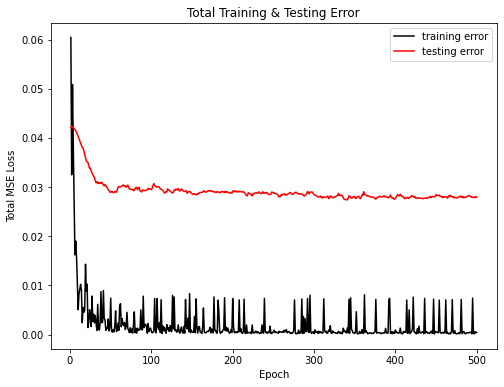

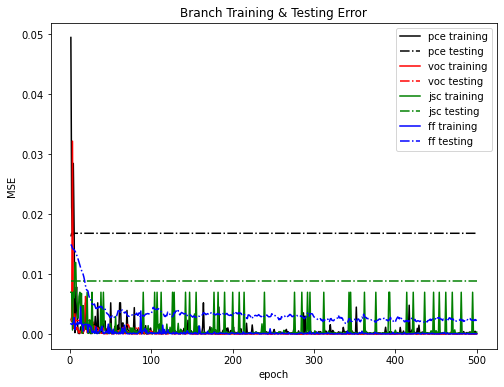

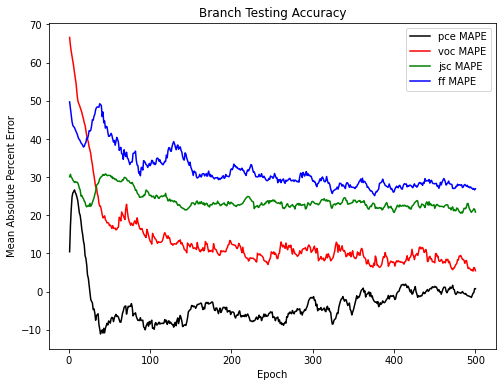

In [9]:
%autoreload
epochs = np.arange(1, (num_epochs+1), 1)

nuts.plot_OPV_df_loss(epochs, train_epoch_losses, test_epoch_losses,
                     pce_train_epoch_losses, pce_test_epoch_losses,
                     voc_train_epoch_losses, voc_test_epoch_losses,
                     jsc_train_epoch_losses, jsc_test_epoch_losses,
                     ff_train_epoch_losses, ff_test_epoch_losses)

nuts.plot_OPV_df_accuracies(epochs, pce_test_epoch_accuracies, voc_test_epoch_accuracies, 
                           jsc_test_epoch_accuracies, ff_test_epoch_accuracies)

In [10]:
model.eval()

with torch.no_grad():
    for inputs, pce_labels, voc_labels, jsc_labels, ff_labels in testing_data_set:
        inputs = inputs.to(device)
        pce_labels = pce_labels.to(device)
        voc_labels = voc_labels.to(device)
        jsc_labels = jsc_labels.to(device)
        ff_labels = ff_labels.to(device)

        PCE_out, Voc_out, Jsc_out, FF_out = model(inputs)


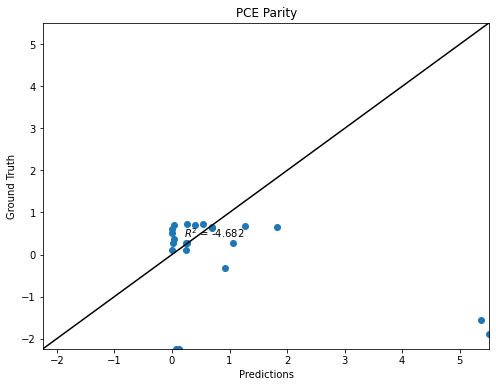

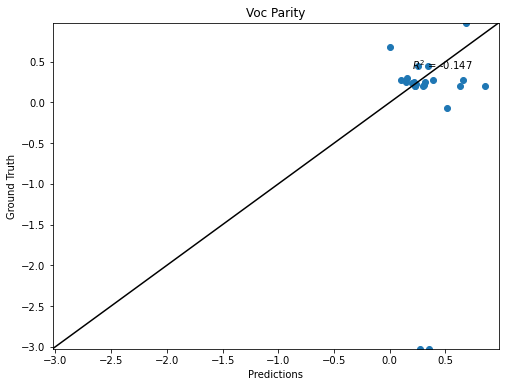

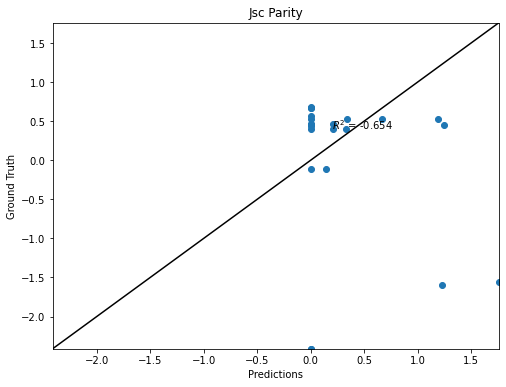

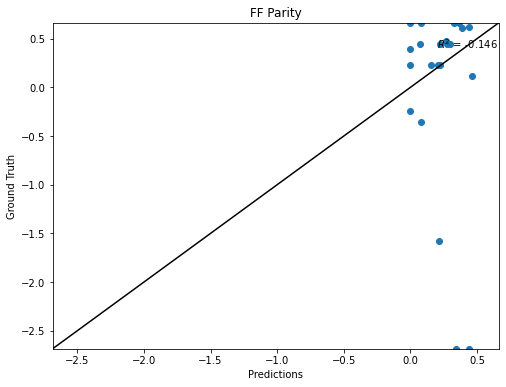

In [11]:
%autoreload

nuts.plot_OPV_parity(pce_labels, PCE_out, voc_labels, Voc_out, jsc_labels, Jsc_out, ff_labels, FF_out)